Import simulator and utilities

In [1]:
from Tfdtd.base import TFDTD2D
from Tfdtd.utilities import print_setup_info
from Tfdtd.detectors import PointDetector
from Tfdtd.sources import PointSource, LineSource

from Tfdtd.geometries import Rectangle, Circle

from Tfdtd.viz import viz2D,viz_detector

### Simulation parameters

###### Geometry parameters

In [2]:
eps = 12          # dielectric constant of waveguide
w = 1.2e-6           # width of waveguide
r = 0.36e-6          # radius of holes
d = 1.4e-6           # defect spacing (ordinary spacing = 1)
N = 3             # number of holes on either side of defect

In [3]:
print('nx',16e-6/50e-9)
print('ny',8e-6/50e-9)
print('w',w/50e-9)
print('r',0.36e-6/50e-9) 
print('d',d/50e-9)
print('ordinary spacing',1e-6/50e-9)

nx 320.0
ny 160.0
w 24.0
r 7.2
d 28.0
ordinary spacing 20.0


In [4]:
params = {
    'backend': 'pytorch',
    'precision': 'float64',
    'nx': 320,
    'ny': 160,
    'time_steps': 5000,
    'dx': 50e-9,
    'dy': 50e-9,
    'polarization': 'TE',
    'use_pml': True,
    'pml_thickness': 20,
}

### Testing initializations

In [5]:
sim = TFDTD2D(params = params)

Reading configuration from dictionary...


### Set geometry

#### Create a switching time serie

In [9]:
import numpy as np

def random_switching_noise(total_time_steps, tau, eps_value1, eps_value2):
    eps_series = np.zeros(total_time_steps)
    current_eps = eps_value1
    time_to_switch = int(np.random.exponential(tau))

    for i in range(total_time_steps):
        if i == time_to_switch:
            current_eps = eps_value2 if current_eps == eps_value1 else eps_value1
            time_to_switch += int(np.random.exponential(tau))

        eps_series[i] = current_eps

    return eps_series


In [17]:
total_time_steps = sim.time_steps
tau = 50
eps_value1 = 8
eps_value2 = 15

eps_series = random_switching_noise(total_time_steps, tau, eps_value1, eps_value2)

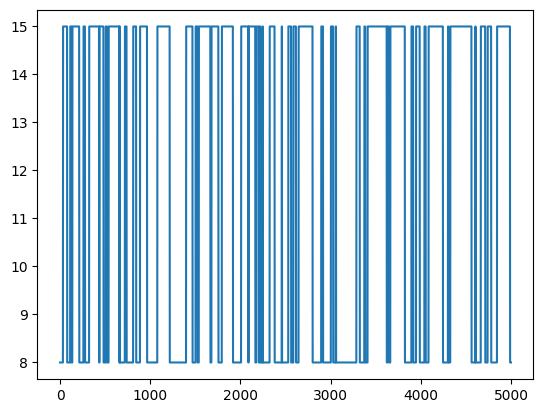

In [18]:
from matplotlib import pyplot as plt
plt.plot(eps_series)
plt.show()

In [19]:
import torch
sim.eps_r_base = torch.ones((sim.nx, sim.ny), dtype=getattr(torch, sim.precision))

In [20]:
def update_base_geometry(sim):
    for geometry in sim.geometries:
        mask = geometry.generate_mask(sim.eps_r_base.shape[0], sim.eps_r_base.shape[1])
        sim.eps_r_base = sim.eps_r_base * (1.0 - mask) + geometry.epsr * mask

In [21]:
rectangle = Rectangle(x1=0, y1=68, x2=sim.nx, y2=92, epsr=eps, sigma=0)
sim.add_geometry(rectangle)

In [22]:
for i in range(0, N):
    circle = Circle(center_x=106+i*20, center_y=80, radius=7.2, epsr=1, sigma=0)
    sim.add_geometry(circle)

for i in range(0, N):
    circle = Circle(center_x=174+i*20, center_y=80, radius=7.2, epsr=1, sigma=0)
    sim.add_geometry(circle)

In [23]:
update_base_geometry(sim)

c:\Users\mazzo\anaconda3\envs\fdtd\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


#### define the time-variant geometry

In [24]:
cavity_x_start = 155
cavity_x_end = 165
cavity_y_start = 68
cavity_y_end = 92

# Modify the permittivity values inside the cavity
for ts in range(sim.time_steps):
    sim.eps_r[:, :, ts] = sim.eps_r_base
    # Update the permittivity values inside the cavity
    sim.eps_r[cavity_x_start:cavity_x_end,cavity_y_start:cavity_y_end,ts] = eps_series[ts]

##### Update the coefcients

In [25]:
sim.calculate_e_field_coefficients()
sim.calculate_h_field_coefficients()

### Set sources

In [16]:
# Conversion from meep to real units
import numpy as np
f_meep  = 0.235 # frequency in meep
c = 2.99e8 # speed of light
a = 1e-6 # Characteristic lenght of the structure
f_real = f_meep * c /a # frequency in real units

print(np.format_float_scientific((f_real), unique=False, precision=2))
#print('speed of light in material',c / np.sqrt(12))

7.03e+13


### Point source

In [26]:
source_params_gaussian = {
    'source_type': 'point_source',  # Add 'source_type' key
    'function': 'gaussian_pulse',
    'source_x': 40,
    'source_y': 80,
    'amplitude': 1.0,
    't0': 0, # t0 is expressed in unit of time not time steps
    'frequency_center': 0.5e14,
    'frequency_width': 0.15e14
}

# source_params_sinusoidal = {
#     'source_type': 'point_source',  # Add 'source_type' key
#     'function': 'sinusoidal',
#     'source_x': 50,
#     'source_y': 82,
#     'frequency': 0.5e14
# }

gaussian_source = PointSource(source_params_gaussian)

#sinusoidal_source = PointSource(source_params_sinusoidal)

### Line source

In [25]:
source_params_gaussian = {
    'source_type': 'line_source',  # Add 'source_type' key
    'function': 'gaussian_pulse',
    'x': 40,
    'y1': 70,
    'y2': 90, 
    'amplitude': 1.0,
    't0': 0, # t0 is expressed in unit of time not time steps
    'frequency_center': 0.7e14,
    'frequency_width': 0.1e14
}

source_params_sinusoidal = {
    'source_type': 'line_source',  # Add 'source_type' key
    'function': 'sinusoidal',
    'x': 40,
    'y1': 70,
    'y2': 90,
    'frequency': 0.5e14
}

gaussian_source = LineSource(source_params_gaussian)
#sinusoidal_source = LineSource(source_params_gaussian)


In [27]:
sim.add_source(gaussian_source)

### Add a detector

In [28]:
detector_params = {
    'name': 'detector1',
    'position': (300, 85),
}

point_detector1 = PointDetector(detector_params)
sim.add_detector(point_detector1)

detector_params = {
    'name': 'detector2',
    'position': (163, 87),
}
point_detector2 = PointDetector(detector_params)
sim.add_detector(point_detector2)

### Print simulation info

In [29]:
print_setup_info(sim)

Simulation setup information:
nx: 320
ny: 160
time_steps: 5000
dx: 5e-08
dy: 5e-08
dt: 1.179327168374842e-16
use_pml: True
pml_thickness: 20
c: 299792458
epsilon_0: 8.85418782e-12
mu_0: 1.25663706e-06
Source 0: source_type: point_source, function: gaussian_pulse, source_x: 40, source_y: 80, amplitude: 1.0, t0: 0, frequency center: 50000000000000.0, frequency width: 15000000000000.0
Detector 0: Detector: detector1, Position: (300, 85)
Detector 1: Detector: detector2, Position: (163, 87)


### Show material distribution

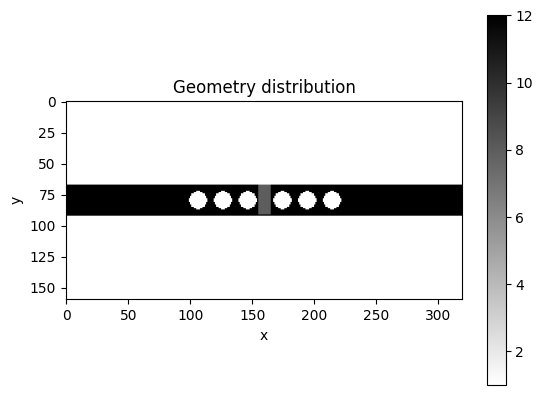

In [30]:
# Visualize permittivity distribution
from matplotlib import pyplot as plt
import numpy as np
plt.imshow(np.transpose(sim.eps_r[:,:,10]), cmap='binary')
plt.title('Geometry distribution')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.show()

### Simulate

In [31]:
sim.run()

100%|██████████| 5000/5000 [00:31<00:00, 159.08it/s]


### Visualize fields

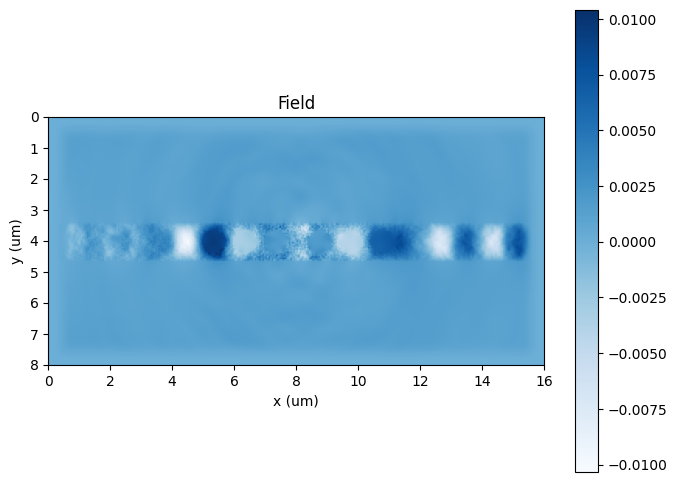

In [32]:

# plot the Ez field with cmap jet
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(np.transpose(sim.h_field[:,:,2]), cmap='Blues', extent=[0, sim.nx*sim.dx*1e6, sim.ny*sim.dy*1e6, 0])
ax.set_xlabel('x (um)')
ax.set_ylabel('y (um)')
ax.set_title('Field')

# plot the geometry mask with cmap binary
#ax.imshow(np.transpose(sim.eps_r), cmap='binary', extent=[0, sim.nx*sim.dx*1e6, sim.ny*sim.dy*1e6, 0],alpha=0.3)

fig.colorbar(im)
plt.show()

### Visualize detector

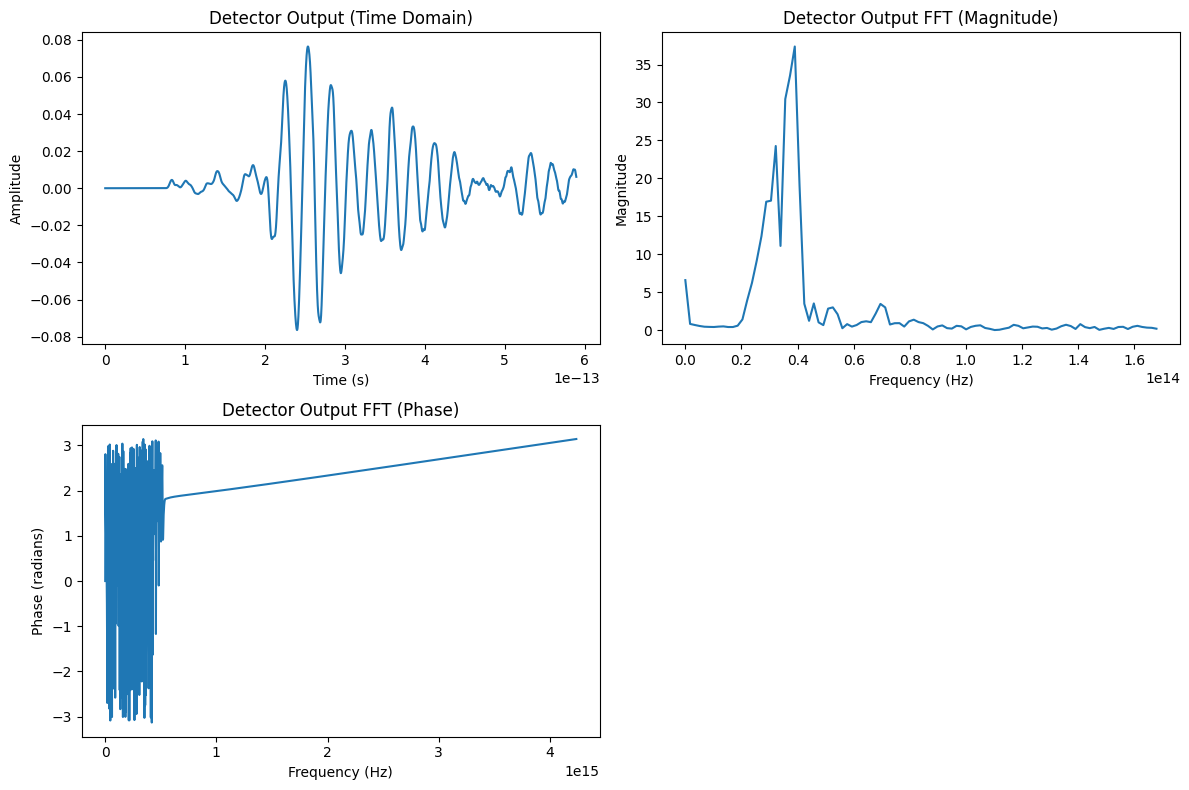

In [34]:
viz_detector(sim,point_detector1)

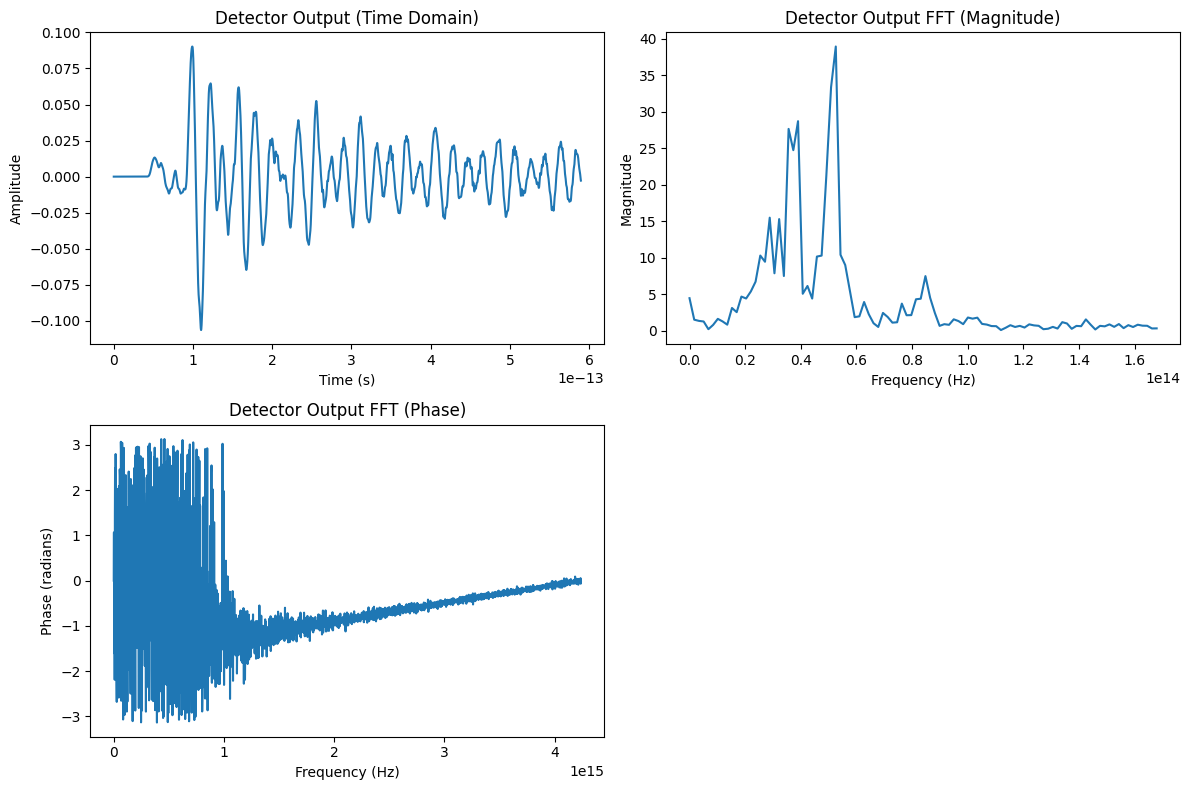

In [35]:
viz_detector(sim,point_detector2)